In [1]:
# 🚀 ML Training Process

# 1. Load the Dataset
import pandas as pd

# Load dataset
df = pd.read_csv("../data/raw_data.csv")

print(df.head())
print(df.info())



  Company_ID  Industry_Type Company_Size Location_Region  \
0      C1790        Textile        Large      Semi-Urban   
1      C0088         Pharma       Medium           Rural   
2      C1372  Manufacturing        Small           Urban   
3      C1509           Food        Large           Urban   
4      C0852     Automobile        Large      Semi-Urban   

   Total_Waste_Generated_kg_per_month  Biodegradable_Waste_%  \
0                            43806.26                     35   
1                             9796.78                     47   
2                             4906.01                     30   
3                            20641.45                     57   
4                            33175.62                     14   

   Recyclable_Waste_%  Hazardous_Waste_%  Waste_Segregation_Level_%  \
0                  50                 15                         65   
1                  37                 16                         84   
2                  36                 34 

In [2]:


# 2. Data Preprocessing

# Separate features (X) and target (y)

# Encode categorical columns (e.g., Industry_Type, Company_Size)

# Scale numeric values if needed


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Target
y = df["Perfect_Waste_Decomposition_System"]

# Drop non-useful ID column
X = df.drop(["Company_ID", "Perfect_Waste_Decomposition_System"], axis=1)

# Encode categorical columns
categorical_cols = X.select_dtypes(include=["object"]).columns
encoder = LabelEncoder()

for col in categorical_cols:
    X[col] = encoder.fit_transform(X[col])

print(X.head())




   Industry_Type  Company_Size  Location_Region  \
0              6             0                1   
1              5             1                0   
2              4             2                2   
3              2             0                2   
4              0             0                1   

   Total_Waste_Generated_kg_per_month  Biodegradable_Waste_%  \
0                            43806.26                     35   
1                             9796.78                     47   
2                             4906.01                     30   
3                            20641.45                     57   
4                            33175.62                     14   

   Recyclable_Waste_%  Hazardous_Waste_%  Waste_Segregation_Level_%  \
0                  50                 15                         65   
1                  37                 16                         84   
2                  36                 34                         61   
3                  38   

In [3]:


# 3. Split into Train & Test Sets

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)




In [4]:


# 4. Train a Classification Model

# You can start with Random Forest, since it handles mixed data well and gives feature importance.

from sklearn.ensemble import RandomForestClassifier

# Train
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)






,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [5]:
# 5. Evaluate the Model

from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# This will give you:

# Precision → How many predicted positives are actually correct

# Recall → How many real positives were found

# F1-score → Balance between precision & recall







Confusion Matrix:
 [[200   0]
 [  0 200]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       200
           1       1.00      1.00      1.00       200

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



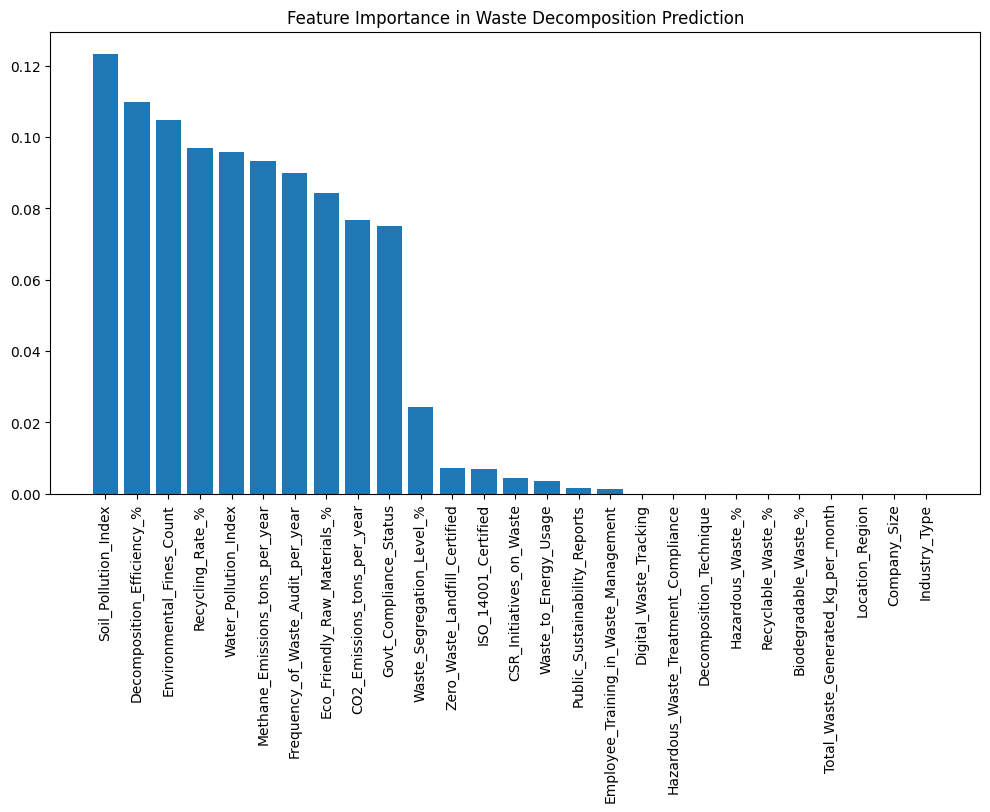

In [6]:
# 6. Check Feature Importance

# To understand which features matter most for prediction:

import matplotlib.pyplot as plt

importances = model.feature_importances_
features = X.columns

# Sort and plot
indices = importances.argsort()[::-1]
plt.figure(figsize=(12,6))
plt.bar(range(len(features)), importances[indices])
plt.xticks(range(len(features)), features[indices], rotation=90)
plt.title("Feature Importance in Waste Decomposition Prediction")
plt.show()






In [7]:
# 7. Try Other Models (Optional)

# You can also test:

# Logistic Regression (simple baseline)

# XGBoost / LightGBM (strong classifiers for tabular data)

# Neural Network (if dataset grows larger)





# 8. Save the Model for Future Use

import joblib
import os

os.makedirs('../model', exist_ok=True)
joblib.dump(model, "../model/waste_decomposition_model.pkl")
print("✅ Model saved as waste_decomposition_model.pkl")






✅ Model saved as waste_decomposition_model.pkl


In [8]:
# ⚡ Workflow Recap:

# 1. Load data


# 2. Clean & encode


# 3. Train-test split


# 4. Train classifier


# 5. Evaluate results


# 6. Analyze feature importance


# 7. Save model